# Tweet Disaster Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
import random
import re # regular expression
from collections import Counter
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.display import display, HTML
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.metrics import classification_report
from tqdm import tqdm, tqdm_notebook # show progress bar

# PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import tensorflow as tf

# nltk text processors
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.style.use('ggplot')
tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

df_train = pd.read_csv("/content/drive/MyDrive/tweet/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/tweet/test.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
print("Training set shape:", df_train.shape)
print("Test set shape:", df_test.shape)
print("\nColumns in train:", df_train.columns.tolist())
print("Columns in test:", df_test.columns.tolist())

Training set shape: (7613, 5)
Test set shape: (3263, 4)

Columns in train: ['id', 'keyword', 'location', 'text', 'target']
Columns in test: ['id', 'keyword', 'location', 'text']


In [ ]:
print('Number of positive reviews:', len(df_train[df_train.target == 1]))
print('Number of negative reviews:', len(df_train[df_train.target == 0]), '\n')

Number of positive reviews: 3271
Number of negative reviews: 4342 



In [ ]:
#sample from train set
display(df_train.sample(5, random_state=10))

,id,keyword,location,text,target
6524,9332,survive,NaN,@DDNewsLive @NitishKumar and @ArvindKejriwal ...,0
701,1009,blazing,NaN,@ACOUSTICMALOLEY no he was blazing it,0
3119,4479,electrocuted,"Redondo Beach, CA",Do babies actually get electrocuted from wall ...,1
4204,5972,hazard,Massachusetts,Precious cargo onesie recalled for choking haz...,0
1651,2386,collapsed,NaN,My portable closet has collapsed 3x and it fin...,0


In [ ]:
#sample from train set
display(df_test.sample(5, random_state=50))

,id,keyword,location,text
1069,3539,derailment,Mumbai,Latest : Suresh Prabhu calls Harda derailment ...
2679,8929,snowstorm,Northeast United States,RT @WhistlerBlckcmb: One more #SnowBackSunday ...
734,2384,collapsed,"Jersey City, NJ",@michaelgbaron Panic City has collapsed. Party...
549,1794,buildings%20on%20fire,"ÌÏT: 41.373061,-71.942237",@gilsimmons lightening struck &amp; 2 units in...
2635,8814,sirens,62,I'm falling to pieces and I won't be whole unt...


## Preprocess Text

* Replace weird characters
* Lowercase
* Tokenize
* Remove stopwords
* Stemming & Lemmatize

#### example

In [ ]:
# test_corpus = '''The Intel Core i5 processor that comes with the Dell Latitude 5490 is quad-core and offers 1.6GHz and a 6M cache. The base configuration includes 1 x 4GB of DDR4 Non-CC memory, but this can be upgraded to 8GB or even 16GB (2 x 8GB) if you require more memory. How great is that!?
# The 14-inch display is available with your choice of 1366 x 768 or 1920 x 1080 resolution. Both versions are non-touch, WLAN capable, and come with anti-glare technology. You also get a built-in camera and microphone. For wireless technology, the system comes with a Qualcomm QCA61 x 4A 802.11 ac (2×2) wireless adapter+.
# '''

test_corpus = '''The Intel Core i5 processor that comes with the Dell Latitude 5490 is quad-core and offers 1.6GHz and a 6M cache. The base configuration includes 1 x 4GB of DDR4 Non-CC memory, but this can be upgraded to 8GB or even 16GB (2 x 8GB) if you require more memory. How great is that!?'''
test_corpus

'The Intel Core i5 processor that comes with the Dell Latitude 5490 is quad-core and offers 1.6GHz and a 6M cache. The base configuration includes 1 x 4GB of DDR4 Non-CC memory, but this can be upgraded to 8GB or even 16GB (2 x 8GB) if you require more memory. How great is that!?'

In [ ]:
# remove special characters & lowercase
clean_corpus = re.sub(r'[^\w\s]', '', test_corpus)
clean_corpus = clean_corpus.lower()
clean_corpus

'the intel core i5 processor that comes with the dell latitude 5490 is quadcore and offers 16ghz and a 6m cache the base configuration includes 1 x 4gb of ddr4 noncc memory but this can be upgraded to 8gb or even 16gb 2 x 8gb if you require more memory how great is that'

In [ ]:
# tokenize
clean_tokens = wordpunct_tokenize(clean_corpus)
print(clean_tokens)

['the', 'intel', 'core', 'i5', 'processor', 'that', 'comes', 'with', 'the', 'dell', 'latitude', '5490', 'is', 'quadcore', 'and', 'offers', '16ghz', 'and', 'a', '6m', 'cache', 'the', 'base', 'configuration', 'includes', '1', 'x', '4gb', 'of', 'ddr4', 'noncc', 'memory', 'but', 'this', 'can', 'be', 'upgraded', 'to', '8gb', 'or', 'even', '16gb', '2', 'x', '8gb', 'if', 'you', 'require', 'more', 'memory', 'how', 'great', 'is', 'that']


In [ ]:
lemmatizer = WordNetLemmatizer()
clean_tokens = [lemmatizer.lemmatize(token) for token in clean_tokens]
clean_tokens = [lemmatizer.lemmatize(token, "v") for token in clean_tokens]
print(clean_tokens)

['the', 'intel', 'core', 'i5', 'processor', 'that', 'come', 'with', 'the', 'dell', 'latitude', '5490', 'be', 'quadcore', 'and', 'offer', '16ghz', 'and', 'a', '6m', 'cache', 'the', 'base', 'configuration', 'include', '1', 'x', '4gb', 'of', 'ddr4', 'noncc', 'memory', 'but', 'this', 'can', 'be', 'upgrade', 'to', '8gb', 'or', 'even', '16gb', '2', 'x', '8gb', 'if', 'you', 'require', 'more', 'memory', 'how', 'great', 'be', 'that']


In [ ]:
clean_tokens = [re.sub(r'\b[0-9]+\b', '<NUM>', token) for token in clean_tokens]
print(clean_tokens)

['the', 'intel', 'core', 'i5', 'processor', 'that', 'come', 'with', 'the', 'dell', 'latitude', '<NUM>', 'be', 'quadcore', 'and', 'offer', '16ghz', 'and', 'a', '6m', 'cache', 'the', 'base', 'configuration', 'include', '<NUM>', 'x', '4gb', 'of', 'ddr4', 'noncc', 'memory', 'but', 'this', 'can', 'be', 'upgrade', 'to', '8gb', 'or', 'even', '16gb', '<NUM>', 'x', '8gb', 'if', 'you', 'require', 'more', 'memory', 'how', 'great', 'be', 'that']


In [ ]:
stop_words = set(stopwords.words('english'))
clean_tokens = [token for token in clean_tokens if token not in stop_words]
print(clean_tokens)

['intel', 'core', 'i5', 'processor', 'come', 'dell', 'latitude', '<NUM>', 'quadcore', 'offer', '16ghz', '6m', 'cache', 'base', 'configuration', 'include', '<NUM>', 'x', '4gb', 'ddr4', 'noncc', 'memory', 'upgrade', '8gb', 'even', '16gb', '<NUM>', 'x', '8gb', 'require', 'memory', 'great']


In [ ]:
def build_vocab(corpus):
    vocab = {}
    for doc in corpus:
        for token in doc:
            if token not in vocab.keys():
                vocab[token] = len(vocab)
    return vocab

print(build_vocab([clean_tokens]))

{'intel': 0, 'core': 1, 'i5': 2, 'processor': 3, 'come': 4, 'dell': 5, 'latitude': 6, '<NUM>': 7, 'quadcore': 8, 'offer': 9, '16ghz': 10, '6m': 11, 'cache': 12, 'base': 13, 'configuration': 14, 'include': 15, 'x': 16, '4gb': 17, 'ddr4': 18, 'noncc': 19, 'memory': 20, 'upgrade': 21, '8gb': 22, 'even': 23, '16gb': 24, 'require': 25, 'great': 26}


In [ ]:
def build_index2token(vocab):
    index2token = {}
    for token in vocab.keys():
        index2token[vocab[token]] = token
    return index2token

print(build_index2token(build_vocab([clean_tokens])))

{0: 'intel', 1: 'core', 2: 'i5', 3: 'processor', 4: 'come', 5: 'dell', 6: 'latitude', 7: '<NUM>', 8: 'quadcore', 9: 'offer', 10: '16ghz', 11: '6m', 12: 'cache', 13: 'base', 14: 'configuration', 15: 'include', 16: 'x', 17: '4gb', 18: 'ddr4', 19: 'noncc', 20: 'memory', 21: 'upgrade', 22: '8gb', 23: 'even', 24: '16gb', 25: 'require', 26: 'great'}


### apply to dataset by using TF-IDF vectorization

In [ ]:
# ================
# Text Preprocessing
# ================

# Initialize tools
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # 0. Remove links and leftover tokens like http, tco, co, amp
    text = re.sub(r"http\S+|www\S+", "", str(text))          # remove complete URLs
    text = re.sub(r"\bhttp\b|\bhttps\b", "", text)           # remove bare http/https
    text = re.sub(r"\btco\b|\bco\b|\bamp\b", "", text)       # remove Twitter artifacts

    # 1. Replace weird characters (keep letters and numbers, replace the rest with space)
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)

    # 2. Lowercase
    text = text.lower()

    # 3. Tokenize
    tokens = wordpunct_tokenize(text)

    # 4. Remove stopwords + short tokens
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]

    # 5. Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)

# Apply preprocessing
tqdm.pandas(desc="Preprocessing text")
df_train["clean_text"] = df_train["text"].progress_apply(clean_text)
df_test["clean_text"] = df_test["text"].progress_apply(clean_text)

# Preview results
print("\nOriginal text:\n", df_train["text"].iloc[0])
print("\nCleaned text:\n", df_train["clean_text"].iloc[0])


Preprocessing text: 100%|██████████| 3263/3263 [00:00<00:00, 5007.36it/s]


Original text:
 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

Cleaned text:
 deed reason earthquake may allah forgive



🔹 Random Examples After Cleaning:

Original : annihilating quarterstaff of annihilation
Cleaned  : annihilating quarterstaff annihilation

Original : Truth...
https://t.co/k44tL3rfMy
#News
#BBC
#CNN
#Islam
#Truth
#god
#ISIS
#terrorism
#Quran
#Lies http://t.co/ipT0hoNoTI
Cleaned  : truth news bbc cnn islam truth god isi terrorism quran lie

Original : during drag me down last night I was screaming 'shell of a mannequin' instead of 'shell of a man' and I think everyone hated me there
Cleaned  : drag last night screaming shell mannequin instead shell man think everyone hated

🔹 Top 20 Most Common Words:
[('fire', 356), ('like', 350), ('get', 255), ('new', 228), ('via', 220), ('one', 209), ('people', 201), ('news', 200), ('year', 177), ('video', 175), ('time', 166), ('disaster', 161), ('emergency', 159), ('body', 155), ('day', 147), ('police', 143), ('home', 143), ('building', 141), ('would', 137), ('family', 132)]

🔹 Length Comparison (Original vs Cleaned):
       orig_length  clean_leng

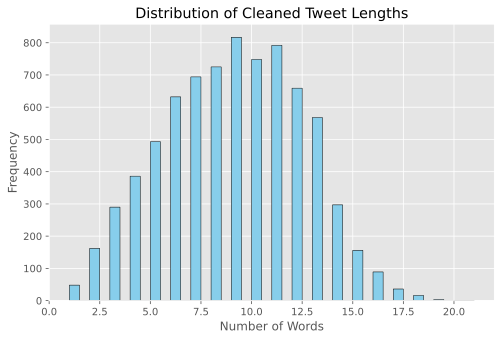

In [ ]:
# ============================
# Inspect Preprocessing Results
# ============================

# 1. Show random examples
print("\n🔹 Random Examples After Cleaning:")
for i in np.random.choice(len(df_train), 3, replace=False):
    print(f"\nOriginal : {df_train['text'].iloc[i]}")
    print(f"Cleaned  : {df_train['clean_text'].iloc[i]}")

# 2. Most common words
from collections import Counter
all_words = " ".join(df_train["clean_text"]).split()
word_counts = Counter(all_words)
print("\n🔹 Top 20 Most Common Words:")
print(word_counts.most_common(20))

# 3. Average length before vs after cleaning
df_train["orig_length"] = df_train["text"].apply(lambda x: len(str(x).split()))
df_train["clean_length"] = df_train["clean_text"].apply(lambda x: len(str(x).split()))

print("\n🔹 Length Comparison (Original vs Cleaned):")
print(df_train[["orig_length", "clean_length"]].describe())

# 4. Plot distribution of tweet lengths after cleaning
plt.figure(figsize=(8,5))
df_train["clean_length"].hist(bins=40, color="skyblue", edgecolor="black")
plt.title("Distribution of Cleaned Tweet Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Optional cleanup: remove 'amp' and ensure text is string
df_train['clean_text'] = df_train['clean_text'].astype(str).str.replace(r'\bamp\b', ' ', regex=True)
df_train['clean_text'] = df_train['clean_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Fit TF-IDF ONCE on the whole training set (shared vocabulary)
vectorizer = TfidfVectorizer(
    max_features=3000,
    min_df=5,        # ignore very rare tokens
    max_df=0.85,     # ignore extremely common tokens
    ngram_range=(1,1),
    sublinear_tf=True
)
vectorizer.fit(df_train['clean_text'].tolist())   # fit on entire train set (not per-class)
features = np.array(vectorizer.get_feature_names_out())

# Transform per-class using the same fitted vectorizer
X_all = vectorizer.transform(df_train['clean_text'].tolist())

Top TF-IDF words (Disaster):
fire                 0.0257
california           0.0127
news                 0.0125
disaster             0.0119
storm                0.0116
via                  0.0115
building             0.0110
suicide              0.0109
police               0.0109
home                 0.0105
year                 0.0103
train                0.0103
hiroshima            0.0100
people               0.0095
wildfire             0.0094
family               0.0094
crash                0.0093
killed               0.0092
emergency            0.0092
accident             0.0091

Top TF-IDF words (Non-Disaster):
like                 0.0179
get                  0.0144
new                  0.0126
one                  0.0107
body                 0.0096
love                 0.0095
day                  0.0088
video                0.0085
would                0.0084
time                 0.0084
know                 0.0082
via                  0.0080
let                  0.0079
emergency    

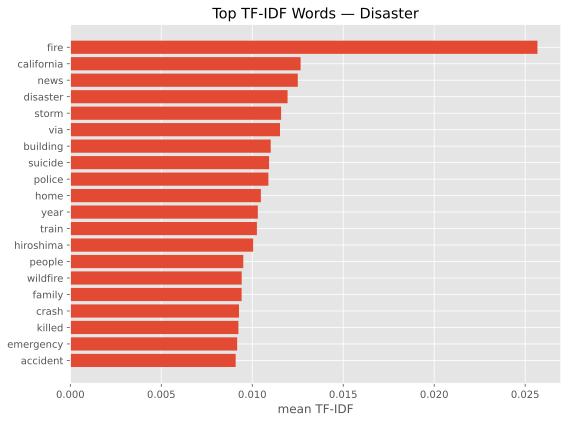

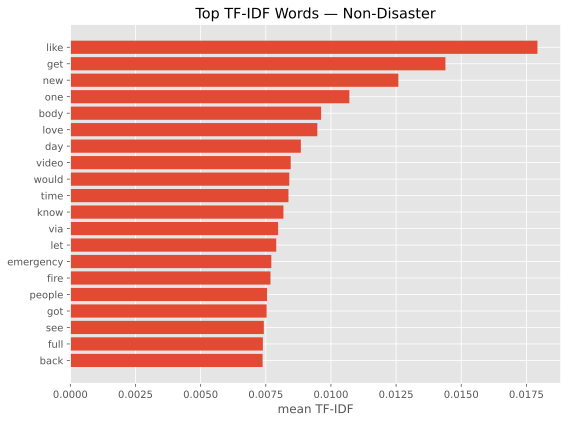

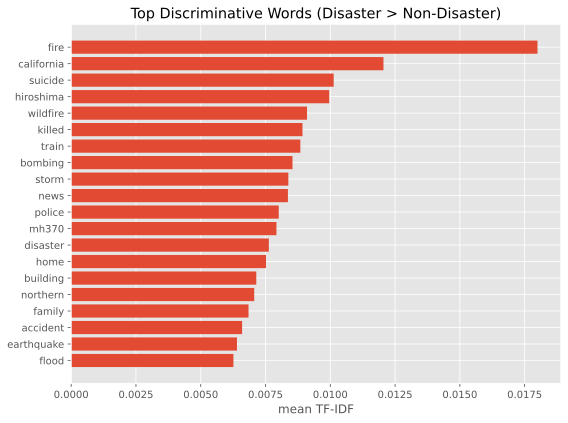

In [ ]:
# @title
# Compute mean TF-IDF per feature for each class
mask_dis = (df_train['target'].values == 1)
X_dis = X_all[mask_dis]
X_non = X_all[~mask_dis]
mean_dis = np.asarray(X_dis.mean(axis=0)).ravel()
mean_non = np.asarray(X_non.mean(axis=0)).ravel()

# Top k words by mean TF-IDF per class
topn = 20
top_dis_idx = mean_dis.argsort()[::-1][:topn]
top_non_idx = mean_non.argsort()[::-1][:topn]

print("Top TF-IDF words (Disaster):")
for i in top_dis_idx:
    print(f"{features[i]:<20} {mean_dis[i]:.4f}")

print("\nTop TF-IDF words (Non-Disaster):")
for i in top_non_idx:
    print(f"{features[i]:<20} {mean_non[i]:.4f}")

# Top discriminative words: mean_dis - mean_non
diff = mean_dis - mean_non
top_diff_idx = diff.argsort()[::-1][:topn]
print("\nTop discriminative words (Disaster > Non-Disaster):")
for i in top_diff_idx:
    print(f"{features[i]:<20} {diff[i]:.4f} (dis:{mean_dis[i]:.4f} non:{mean_non[i]:.4f})")

# OPTIONAL: plots for visualization
def bar_plot_top(indices, scores, title):
    words = features[indices][::-1]
    vals  = scores[indices][::-1]
    plt.figure(figsize=(8,6))
    plt.barh(range(len(words)), vals)
    plt.yticks(range(len(words)), words)
    plt.title(title)
    plt.xlabel("mean TF-IDF")
    plt.tight_layout()
    plt.show()

bar_plot_top(top_dis_idx, mean_dis, "Top TF-IDF Words — Disaster")
bar_plot_top(top_non_idx, mean_non, "Top TF-IDF Words — Non-Disaster")
bar_plot_top(top_diff_idx, diff, "Top Discriminative Words (Disaster > Non-Disaster)")

### Split into training, validation, and test sets
- **Training**: data the model learns from
- **Validation**: data to evaluate with for hyperparameter tuning (make sure the model doesn't overfit!)
- **Testing**: data to evaluate the final performance of the model

In [ ]:
from sklearn.model_selection import train_test_split

X_test = df_test["clean_text"]
y = df_train["target"].values  # labels

X_train, X_val, y_train, y_val = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)

## ML based model

###LR

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [ ]:
# ==========================
# Train Logistic Regression Model
# ==========================
log_reg = LogisticRegression(max_iter=3000, C=1.0, solver='lbfgs')
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=3000)


=== Classification Report (Validation) ===
              precision    recall  f1-score   support

Not Disaster       0.81      0.90      0.85       869
    Disaster       0.84      0.72      0.77       654

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



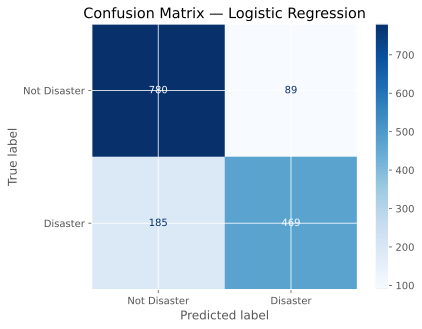

In [ ]:
# ==========================
# Evaluate Model
# ==========================
y_pred = log_reg.predict(X_val)

print("\n=== Classification Report (Validation) ===")
print(classification_report(y_val, y_pred, target_names=["Not Disaster", "Disaster"]))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Disaster", "Disaster"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# ==========================
# Train Random Forest Model
# ==========================
rf_clf = RandomForestClassifier(
    n_estimators=200,        # number of trees
    max_depth=30,           # prevent overfitting
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)


=== Classification Report (Validation) ===
              precision    recall  f1-score   support

Not Disaster       0.71      0.96      0.81       869
    Disaster       0.90      0.47      0.62       654

    accuracy                           0.75      1523
   macro avg       0.80      0.71      0.71      1523
weighted avg       0.79      0.75      0.73      1523



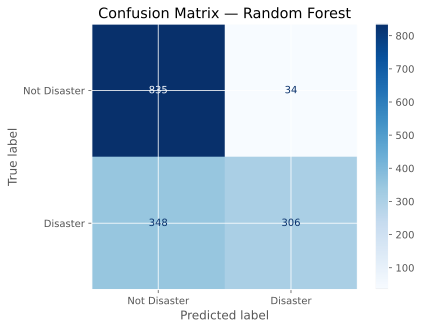

In [ ]:
# ==========================
# Evaluate Model
# ==========================
y_pred = rf_clf.predict(X_val)

print("\n=== Classification Report (Validation) ===")
print(classification_report(y_val, y_pred, target_names=["Not Disaster", "Disaster"]))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Disaster", "Disaster"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix — Random Forest")
plt.show()

### Naive-Bayes

In [ ]:
# ==========================
# Train Naive Bayes Model
# ==========================
from sklearn.naive_bayes import MultinomialNB

nb_clf = MultinomialNB(alpha=0.5)  # alpha = smoothing parameter
nb_clf.fit(X_train, y_train)

MultinomialNB(alpha=0.5)


=== Classification Report (Validation) ===
              precision    recall  f1-score   support

Not Disaster       0.81      0.90      0.85       869
    Disaster       0.84      0.72      0.77       654

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



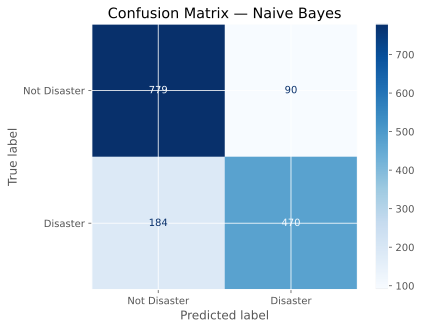

In [ ]:
# ==========================
# Evaluate Model
# ==========================
y_pred = nb_clf.predict(X_val)

print("\n=== Classification Report (Validation) ===")
print(classification_report(y_val, y_pred, target_names=["Not Disaster", "Disaster"]))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Disaster", "Disaster"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix — Naive Bayes")
plt.show()

### Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and train
svm_clf = LinearSVC(C=1.0, max_iter=3000)
svm_clf.fit(X_train, y_train)

# Predict
y_pred = svm_clf.predict(X_val)

Validation Accuracy: 0.8023637557452397

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       869
           1       0.78      0.75      0.76       654

    accuracy                           0.80      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523



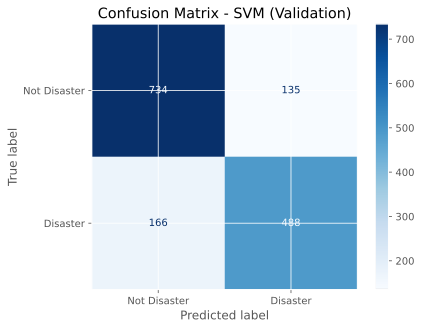

In [ ]:
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Confusion matrix
cm_nb = confusion_matrix(y_val, y_pred)
disp_nb = ConfusionMatrixDisplay(cm_nb, display_labels=["Not Disaster", "Disaster"])
disp_nb.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM (Validation)")
plt.show()

## Transformer-based model

#### Split raw dataset

TF-IDF features (X_all) for traditional ML models (like SVM, Logistic Regression, Random Forest, Naive Bayes).

However, DistilBERT (and any Transformer model) doesn’t take numerical TF-IDF vectors — it requires raw text input (strings).

In [ ]:
# Train/Validation Split
from sklearn.model_selection import train_test_split

X_train_texts, X_val_texts, y_train, y_val = train_test_split(
    df_train['clean_text'].tolist(),
    df_train['target'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_train['target'].tolist()
)

X_test_texts = df_test['clean_text'].tolist()

calculate metrics

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

### DistilBERT

In [ ]:
# Tokenization
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch, padding="max_length", truncation=True, max_length=160)

train_encodings = tokenize(X_train_texts)
val_encodings   = tokenize(X_val_texts)
test_encodings  = tokenize(X_test_texts)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Torch Dataset
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.encodings['input_ids'])
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TweetDataset(train_encodings, y_train)
val_dataset   = TweetDataset(val_encodings, y_val)
test_dataset  = TweetDataset(test_encodings)

In [ ]:
#model
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=50
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

/tmp/ipython-input-3523067795.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 20127578 (20127578-tr-ng-i-h-c-khoa-h-c-t-nhi-n-hqg-hcm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.462600,0.403820,0.841760,0.855422,0.759939,0.804858
2,0.366600,0.424013,0.827315,0.787923,0.818043,0.802701


TrainOutput(global_step=762, training_loss=0.4080442994285443, metrics={'train_runtime': 238.8541, 'train_samples_per_second': 254.967, 'train_steps_per_second': 15.951, 'total_flos': 504204036134400.0, 'train_loss': 0.4080442994285443, 'epoch': 2.0})

Validation Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.83      0.90      0.87       869
    Disaster       0.86      0.76      0.80       654

    accuracy                           0.84      1523
   macro avg       0.84      0.83      0.84      1523
weighted avg       0.84      0.84      0.84      1523



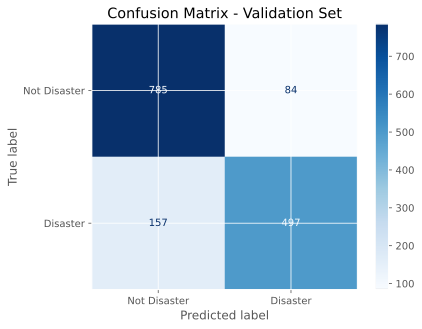

In [ ]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

val_preds = trainer.predict(val_dataset)
y_pred = val_preds.predictions.argmax(-1)

print("Validation Classification Report:")
print(classification_report(y_val, y_pred, target_names=["Not Disaster", "Disaster"]))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Not Disaster", "Disaster"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()

### BERT

In [ ]:
# Prepare tokenizer & model
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize datasets

def tokenize(batch):
    return tokenizer(batch, padding="max_length", truncation=True, max_length=160)

train_encodings = tokenize(X_train_texts)
val_encodings   = tokenize(X_val_texts)
test_encodings  = tokenize(X_test_texts)

In [ ]:
# Torch Dataset
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.encodings['input_ids'])
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TweetDataset(train_encodings, y_train)
val_dataset   = TweetDataset(val_encodings, y_val)
test_dataset  = TweetDataset(test_encodings)

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

# Training
training_args = TrainingArguments(
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=50
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

/tmp/ipython-input-4090763315.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.485000,0.410523,0.842416,0.876364,0.737003,0.800664
2,0.367500,0.420399,0.824032,0.782991,0.816514,0.799401


TrainOutput(global_step=762, training_loss=0.41988665913659445, metrics={'train_runtime': 377.0377, 'train_samples_per_second': 161.522, 'train_steps_per_second': 10.105, 'total_flos': 1001466454464000.0, 'train_loss': 0.41988665913659445, 'epoch': 2.0})

Validation Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.82      0.92      0.87       869
    Disaster       0.88      0.74      0.80       654

    accuracy                           0.84      1523
   macro avg       0.85      0.83      0.84      1523
weighted avg       0.85      0.84      0.84      1523



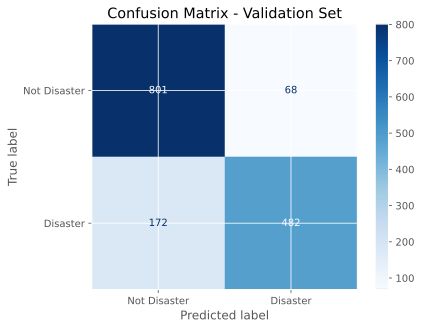

In [ ]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

val_preds = trainer.predict(val_dataset)
y_pred = val_preds.predictions.argmax(-1)

print("Validation Classification Report:")
print(classification_report(y_val, y_pred, target_names=["Not Disaster", "Disaster"]))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Not Disaster", "Disaster"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()

Validation Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.84      0.88      0.86       869
    Disaster       0.84      0.78      0.81       654

    accuracy                           0.84      1523
   macro avg       0.84      0.83      0.83      1523
weighted avg       0.84      0.84      0.84      1523



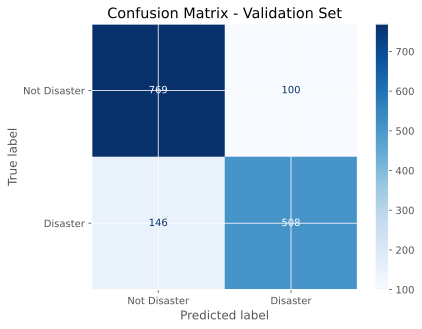

In [ ]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

val_preds = trainer.predict(val_dataset)
y_pred = val_preds.predictions.argmax(-1)

print("Validation Classification Report:")
print(classification_report(y_val, y_pred, target_names=["Not Disaster", "Disaster"]))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Not Disaster", "Disaster"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()

### ModernBERT-base

In [ ]:
# Tokenization
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")

def tokenize(batch):
    return tokenizer(batch, padding="max_length", truncation=True, max_length=160)

train_encodings = tokenize(X_train_texts)
val_encodings   = tokenize(X_val_texts)
test_encodings  = tokenize(X_test_texts)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [ ]:
# Torch Dataset
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.encodings['input_ids'])
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TweetDataset(train_encodings, y_train)
val_dataset   = TweetDataset(val_encodings, y_val)
test_dataset  = TweetDataset(test_encodings)

In [ ]:
#model
from transformers import ModernBertForSequenceClassification

model = ModernBertForSequenceClassification.from_pretrained("answerdotai/ModernBERT-base", num_labels=2)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

# Training
training_args = TrainingArguments(
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=50
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

/tmp/ipython-input-1008341078.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.487000,0.415481,0.823375,0.807018,0.773700,0.790008
2,0.351100,0.420413,0.830598,0.831104,0.759939,0.793930


TrainOutput(global_step=762, training_loss=0.397809040828014, metrics={'train_runtime': 560.6349, 'train_samples_per_second': 21.725, 'train_steps_per_second': 1.359, 'total_flos': 1297009551398400.0, 'train_loss': 0.397809040828014, 'epoch': 2.0})

Validation Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.83      0.88      0.86       869
    Disaster       0.83      0.76      0.79       654

    accuracy                           0.83      1523
   macro avg       0.83      0.82      0.83      1523
weighted avg       0.83      0.83      0.83      1523



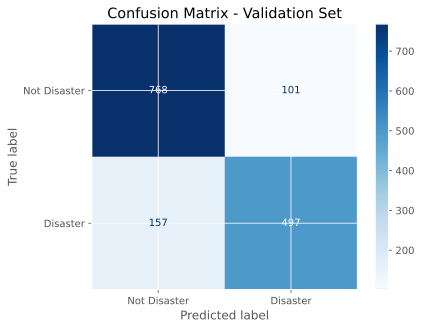

In [ ]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

val_preds = trainer.predict(val_dataset)
y_pred = val_preds.predictions.argmax(-1)

print("Validation Classification Report:")
print(classification_report(y_val, y_pred, target_names=["Not Disaster", "Disaster"]))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Not Disaster", "Disaster"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()

###roberta-base

In [ ]:
# Prepare tokenizer & model
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize datasets

def tokenize(batch):
    return tokenizer(batch, padding="max_length", truncation=True, max_length=160)

train_encodings = tokenize(X_train_texts)
val_encodings   = tokenize(X_val_texts)
test_encodings  = tokenize(X_test_texts)

In [ ]:
# Torch Dataset
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.encodings['input_ids'])
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TweetDataset(train_encodings, y_train)
val_dataset   = TweetDataset(val_encodings, y_val)
test_dataset  = TweetDataset(test_encodings)

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

# Training
training_args = TrainingArguments(
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    metric_for_best_model="f1",
    logging_steps=50
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

/tmp/ipython-input-2439881551.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.483100,0.420397,0.820092,0.785285,0.799694,0.792424
2,0.419000,0.408933,0.836507,0.825040,0.785933,0.805012
3,0.301400,0.417503,0.829284,0.799392,0.804281,0.801829


TrainOutput(global_step=1143, training_loss=0.407868632285718, metrics={'train_runtime': 585.727, 'train_samples_per_second': 51.987, 'train_steps_per_second': 3.252, 'total_flos': 1502199681696000.0, 'train_loss': 0.407868632285718, 'epoch': 3.0})


Classification Report:
               precision    recall  f1-score   support

Not Disaster       0.85      0.87      0.86       874
    Disaster       0.82      0.80      0.81       649

    accuracy                           0.84      1523
   macro avg       0.84      0.83      0.84      1523
weighted avg       0.84      0.84      0.84      1523



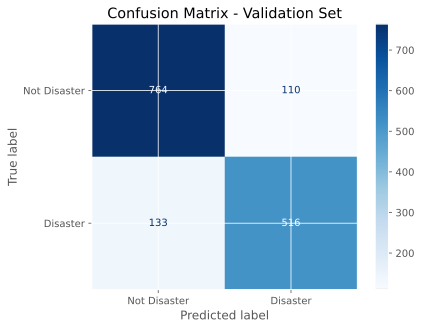

In [ ]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

val_preds = trainer.predict(val_dataset)
y_pred = val_preds.predictions.argmax(-1)

print("Validation Classification Report:")
print(classification_report(y_val, y_pred, target_names=["Not Disaster", "Disaster"]))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Not Disaster", "Disaster"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()